In [2]:
from warnings import filterwarnings
filterwarnings("ignore")

In [6]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("C:/Users/jadha/Downloads/hotel_bookings.csv") 

# Summary of the dataset

print("Data Structure Overview:")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print("\nData Types and Missing Values:")
print(df.info())
print("\nMissing Values Summary:")
print(df.isnull().sum())

Data Structure Overview:
Number of rows: 119390
Number of columns: 32

Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386

In [12]:
 #Handling missing values

df['children'].fillna(0, inplace=True)

df = df.dropna(subset=['arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month'])

# Fill missing values in each column with a reasonable placeholder or statistical value

df['arrival_date_year'].fillna(df['arrival_date_year'].mode()[0], inplace=True)

df['arrival_date_month'].fillna(df['arrival_date_month'].mode()[0], inplace=True)

df['arrival_date_week_number'].fillna(df['arrival_date_week_number'].median(), inplace=True)

df['arrival_date_day_of_month'].fillna(df['arrival_date_day_of_month'].median(), inplace=True)


# Convert to a datetime format
df['arrival_date'] = pd.to_datetime(df['arrival_date_year'].astype(str) + '-' +
                                    df['arrival_date_month'].astype(str) + '-' +
                                    df['arrival_date_day_of_month'].astype(str),
                                    errors='coerce')  # coerce will handle invalid dates as NaT


# Convert data types
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# Feature Engineering: Add useful features, such as length of stay and advance booking days
df['length_of_stay'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
df['days_until_arrival'] = (df['reservation_status_date'] - pd.to_datetime(df['arrival_date'])).dt.days


print("\nData after preprocessing:")
print(df.head())


Data after preprocessing:
          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                        0                     0       2  ...   
1      

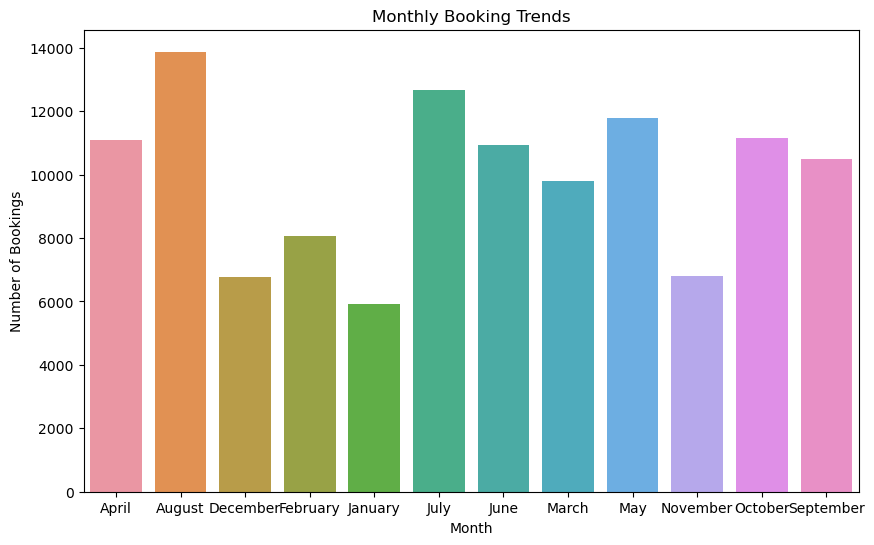

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seasonality in bookings
plt.figure(figsize=(10, 6))
sns.countplot(x='arrival_date_month', data=df, order=sorted(df['arrival_date_month'].unique()))
plt.title('Monthly Booking Trends')
plt.xlabel('Month')
plt.ylabel('Number of Bookings')
plt.show()


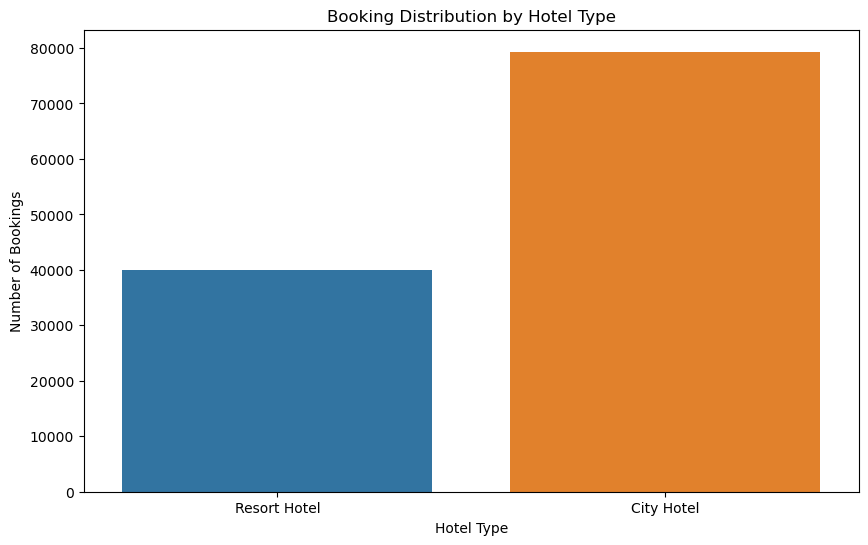

In [16]:
# Distribution of stays across hotel types
plt.figure(figsize=(10, 6))
sns.countplot(x='hotel', data=df)
plt.title('Booking Distribution by Hotel Type')
plt.xlabel('Hotel Type')
plt.ylabel('Number of Bookings')
plt.show()

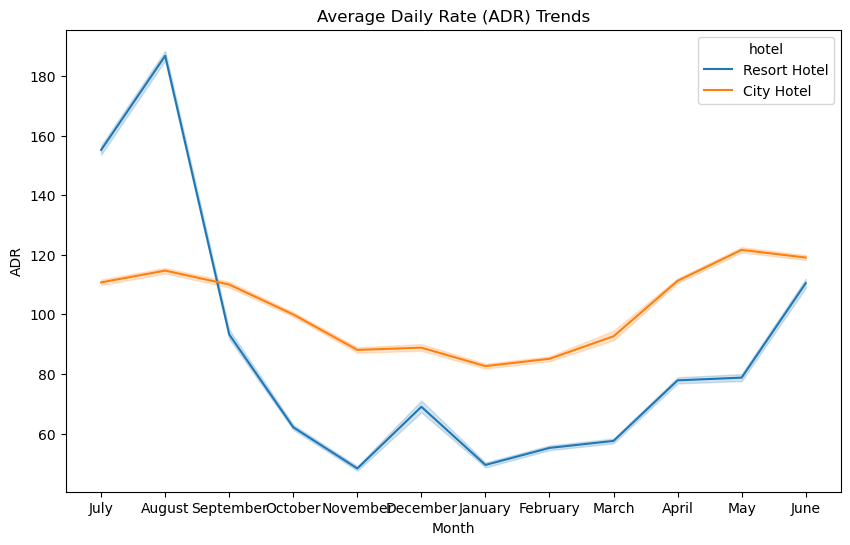

In [19]:
# Average Daily Rate (ADR) trends
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="arrival_date_month", y="adr", hue="hotel")
plt.title('Average Daily Rate (ADR) Trends')
plt.xlabel('Month')
plt.ylabel('ADR')
plt.show()

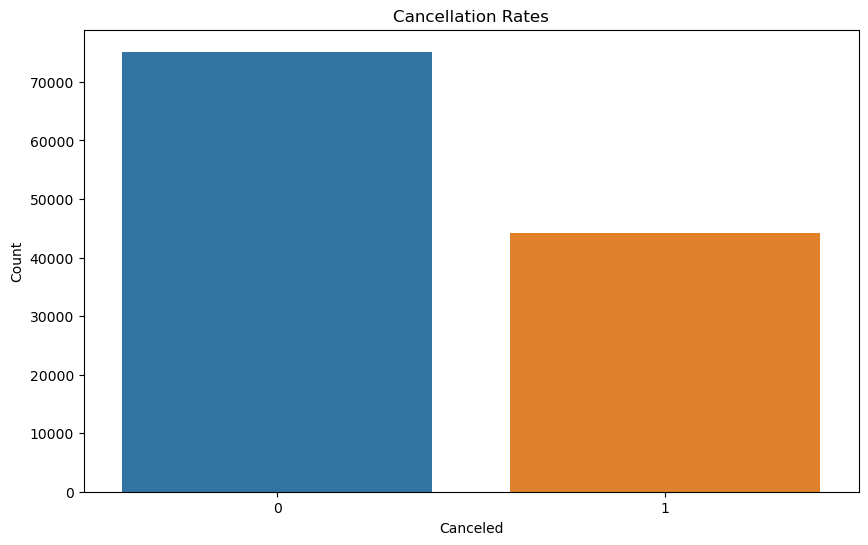

In [22]:
# Cancellation rates and factors affecting cancellations
plt.figure(figsize=(10, 6))
sns.countplot(x='is_canceled', data=df)
plt.title('Cancellation Rates')
plt.xlabel('Canceled')
plt.ylabel('Count')
plt.show()

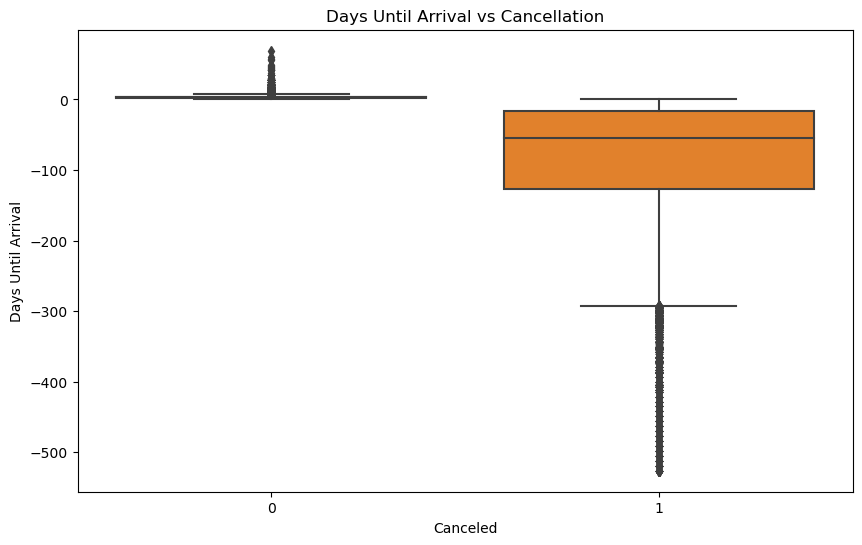

In [24]:
# Investigate factors affecting cancellations
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="is_canceled", y="days_until_arrival")
plt.title('Days Until Arrival vs Cancellation')
plt.xlabel('Canceled')
plt.ylabel('Days Until Arrival')
plt.show()

In [27]:
from scipy.stats import ttest_ind, chi2_contingency

# Hypothesis 1: T-Test for cancellations based on advance booking time
six_months = 180
advance_cancel = df[df['days_until_arrival'] > six_months]['is_canceled']
normal_cancel = df[df['days_until_arrival'] <= six_months]['is_canceled']
t_stat, p_val = ttest_ind(advance_cancel, normal_cancel)

print("Hypothesis 1: T-Test Results")
print(f"T-statistic: {t_stat}, P-value: {p_val}")

Hypothesis 1: T-Test Results
T-statistic: nan, P-value: nan


In [30]:
# Hypothesis 2: T-Test for ADR on weekdays vs. weekends
weekday_adr = df[df['arrival_date_week_number'] <= 5]['adr']  # Adjust this column based on the dataset structure
weekend_adr = df[df['arrival_date_week_number'] > 5]['adr']
t_stat_adr, p_val_adr = ttest_ind(weekday_adr, weekend_adr)

print("\nHypothesis 2: T-Test Results")
print(f"T-statistic: {t_stat_adr}, P-value: {p_val_adr}")


Hypothesis 2: T-Test Results
T-statistic: -51.85511455193849, P-value: 0.0


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Feature Selection
features = ['lead_time', 'length_of_stay', 'days_until_arrival', 'adr']
X = df[features]
y = df['is_canceled']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model 1: Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

In [36]:
 #Model Evaluation
print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg)}")
print(f"Precision: {precision_score(y_test, y_pred_logreg)}")
print(f"Recall: {recall_score(y_test, y_pred_logreg)}")
print(f"F1 Score: {f1_score(y_test, y_pred_logreg)}")

Logistic Regression Performance:
Accuracy: 0.9991903286149035
Precision: 0.9992498124531133
Recall: 0.9985756053677187
F1 Score: 0.9989125951479246


In [38]:
# Model 2: Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)




print("\nRandom Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"Precision: {precision_score(y_test, y_pred_rf)}")
print(f"Recall: {recall_score(y_test, y_pred_rf)}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf)}")



Random Forest Performance:
Accuracy: 0.9996091241589189
Precision: 0.9994752230302122
Recall: 0.9994752230302122
F1 Score: 0.9994752230302122
